In [1]:
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import pickle
import glob

<br> 이번에는 익절/손절라인을 결정할 수 있는 예측모델을 만들어 보겠습니다. 먼저 피쳐가 있는 데이터를 불러옵니다. 

In [43]:
feature_all = pd.read_pickle('feature_all.pkl') 
feature_all['target'] = np.where(feature_all['max_close']>= 1.05, 1, 0)
target = feature_all['target'].mean()
print(f'% of target:{target: 5.1%}')

% of target: 24.3%


<br> 날짜와 종목을 인덱스로 설정합니다. 데이터에 예측모델을 적용하고 매수 대상 종목을 select_top 이라는 DataFrame 에 저장합니다. 

In [44]:
mdl_all = feature_all.set_index([feature_all.index,'code'])

with open("gam.pkl", "rb") as file:
    gam = pickle.load(file) 

feature_list = ['price_z','volume_z','num_high/close','num_win_market','pct_win_market','return over sector']
X = mdl_all[feature_list]
y = mdl_all['target']

yhat = gam.predict_proba(X.to_numpy())
yhat = pd.Series(yhat, name='yhat', index=y.index)

mdl_all['yhat'] = yhat

tops = mdl_all[mdl_all['yhat'] > 0.3].copy()

tops['return_rank']  = pd.qcut(tops['return'], q=3, labels=range(3)) # 종가 수익률
tops['price_rank']  = pd.qcut(tops['price_z'], q=3, labels=range(3)) # 가격 변동성

select_tops = tops[(tops['return_rank']==2) & (tops['price_rank']==0)]

<br> 최저 기대 수익율과 피쳐와의 상관계수를 조사합니다. 예상하지 못햇던 사실은 5 영업일 동안 최저 기대 수익률은 종목보다는 지수 수익률과 더 상관관계가 높습니다. 

In [45]:
select_tops[['return','kosdaq_return','min_close']].corr()

,return,kosdaq_return,min_close
return,1.000000,0.181246,-0.004027
kosdaq_return,0.181246,1.000000,0.194672
min_close,-0.004027,0.194672,1.000000


<br> 'return' 과 'kosdaq_return' 이용해서 단순한 예측모델을 구현합니다. 머신러닝 모델 중 가장 쉽게 접근할 수 있는 랜덤포레스트 회귀모형으로 쉽게 빌드해 봅니다. 그래프를 보니 예측값이 기대 최저 수익률을 잘 따라가는 것으로 보입니다. 

In [88]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=4, min_samples_leaf=30) # 정해진 하이퍼파라미터를 가진 객체를 생성

X = select_tops[['return','kosdaq_return']]
y = select_tops['min_close']

rf.fit(X, y)
yhat = rf.predict(X) # 최저 기대수익율 예측
yhat = pd.Series(yhat, name='min_yhat', index=y.index) 

min_yhat
(0.914, 0.947]    0.931482
(0.947, 0.959]    0.952908
(0.959, 0.971]    0.969847
(0.971, 0.982]    0.978340
(0.982, 1.031]    1.020167
Name: min_close, dtype: float64


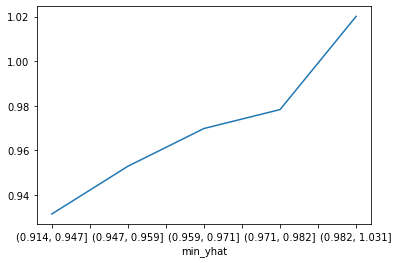

In [89]:
def perf(y, yhat): # 20 Percentile 분석
    combined = pd.concat([y, yhat], axis=1)
    ranks = pd.qcut(combined['min_yhat'], q=5)
    print(combined.groupby(ranks)['min_close'].mean())
    combined.groupby(ranks)['min_close'].mean().plot()

perf(y, yhat)

<br> 만들어진 모델을 pickle 파일로 저장하고, 최소 기대 수익률에 손절라인을 반환하는 함수를 만듭니다.

In [70]:
import pickle
with open("rf.pkl", "wb") as file:
    pickle.dump(rf, file)    
    
with open("rf.pkl", "rb") as file:
    rf = pickle.load(file)     

<br> 위 최소 기대 수익률 값에 따라 아래와 같이 익절/손절 라인을 변동할 수 있도록 합니다. 아래 함수는 익절 수익률과 손절 수익률을 딕셔너리로 반환합니다.

In [90]:
def profit_loss_cut(x):
    
    if x <= 0.95: # 익절 손절 범위 축소
        return 1.04, 0.98 
    
    elif x <= 0.98: 
        return 1.05, 0.97
    
    else: # 익절/손절범위 확대
        return 1.06, 0.96

<br> 종목, 매수가 익절/손절라인 반환하는 함수를 만듭니다.

In [158]:
def select_stocks(today_dt):
    
    today = datetime.datetime.strptime(today_dt, '%Y-%m-%d')
    start_dt = today - datetime.timedelta(days=100) # 100 일전 데이터 부터 시작 - 피쳐 엔지니어링은 최소 60 개의 일봉이 필요함
    print(start_dt, today_dt)

    kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

    price_data = pd.DataFrame()

    for code, name in zip(kosdaq_list['code'], kosdaq_list['name']):  # 코스닥 모든 종목에서 대하여 반복
        daily_price = fdr.DataReader(code, start = start_dt, end = today_dt) # 종목, 일봉, 데이터 갯수

        daily_price['code'] = code
        daily_price['name'] = name
        price_data = pd.concat([price_data, daily_price], axis=0)   

    price_data.index.name = 'date'
    price_data.columns= price_data.columns.str.lower() # 컬럼 이름 소문자로 변경

    kosdaq_index = fdr.DataReader('KQ11', start = start_dt, end = today_dt) # 데이터 호출
    kosdaq_index.columns = ['close','open','high','low','volume','change'] # 컬럼명 변경
    kosdaq_index.index.name='date' # 인덱스 이름 생성
    kosdaq_index.sort_index(inplace=True) # 인덱스(날짜) 로 정렬 
    kosdaq_index['kosdaq_return'] = kosdaq_index['close']/kosdaq_index['close'].shift(1) # 수익율 : 전 날 종가대비 당일 종가

    merged = price_data.merge(kosdaq_index['kosdaq_return'], left_index=True, right_index=True, how='left')

    return_all = pd.DataFrame()

    for code in kosdaq_list['code']:  

        stock_return = merged[merged['code']==code].sort_index()
        stock_return['return'] = stock_return['close']/stock_return['close'].shift(1) # 종목별 전일 종가 대비 당일 종가 수익율
        c1 = (stock_return['kosdaq_return'] < 1) # 수익율 1 보다 작음. 당일 종가가 전일 종가보다 낮음 (코스닥 지표)
        c2 = (stock_return['return'] > 1) # 수익율 1 보다 큼. 당일 종가가 전일 종가보다 큼 (개별 종목)
        stock_return['win_market'] = np.where((c1&c2), 1, 0) # C1 과 C2 조건을 동시에 만족하면 1, 아니면 0
        return_all = pd.concat([return_all, stock_return], axis=0) 

    return_all.dropna(inplace=True)    

    model_inputs = pd.DataFrame()

    for code, name, sector in zip(kosdaq_list['code'], kosdaq_list['name'], kosdaq_list['sector']):

        data = return_all[return_all['code']==code].sort_index().copy()    

        # 가격변동성이 크고, 거래량이 몰린 종목이 주가가 상승한다
        data['price_mean'] = data['close'].rolling(20).mean()
        data['price_std'] = data['close'].rolling(20).std(ddof=0)
        data['price_z'] = (data['close'] - data['price_mean'])/data['price_std']    
        data['volume_mean'] = data['volume'].rolling(20).mean()
        data['volume_std'] = data['volume'].rolling(20).std(ddof=0)
        data['volume_z'] = (data['volume'] - data['volume_mean'])/data['volume_std']

        # 위꼬리가 긴 양봉이 자주발생한다.
        data['positive_candle'] = (data['close'] > data['open']).astype(int) # 양봉
        data['high/close'] = (data['positive_candle']==1)*(data['high']/data['close'] > 1.1).astype(int) # 양봉이면서 고가가 종가보다 높게 위치
        data['num_high/close'] =  data['high/close'].rolling(20).sum()
        data['long_candle'] = (data['positive_candle']==1)*(data['high']==data['close'])*\
        (data['low']==data['open'])*(data['close']/data['open'] > 1.2).astype(int) # 장대 양봉을 데이터로 표현
        data['num_long'] =  data['long_candle'].rolling(60).sum() # 지난 20 일 동안 장대양봉의 갯 수


         # 거래량이 종좀 터지며 매집의 흔적을 보인다   
        data['volume_mean'] = data['volume'].rolling(60).mean()
        data['volume_std'] = data['volume'].rolling(60).std()
        data['volume_z'] = (data['volume'] - data['volume_mean'])/data['volume_std'] # 거래량은 종목과 주가에 따라 다르기 떄문에 표준화한 값이 필요함
        data['z>1.96'] = (data['close'] > data['open'])*(data['volume_z'] > 1.65).astype(int) # 양봉이면서 거래량이 90%신뢰구간을 벗어난 날
        data['num_z>1.96'] =  data['z>1.96'].rolling(60).sum()  # 양봉이면서 거래량이 90% 신뢰구간을 벗어난 날을 카운트

        # 주가지수보다 더 좋은 수익율을 보여준다
        data['num_win_market'] = data['win_market'].rolling(60).sum() # 주가지수 수익율이 1 보다 작을 때, 종목 수익율이 1 보다 큰 날 수
        data['pct_win_market'] = (data['return']/data['kosdaq_return']).rolling(60).mean() # 주가지수 수익율 대비 종목 수익율


        # 동종업체 수익률보다 더 좋은 수익율을 보여준다.           
        data['return_mean'] = data['return'].rolling(60).mean() # 종목별 최근 60 일 수익율의 평균
        data['sector'] = sector    
        data['name'] = name

        data = data[(data['price_std']!=0) & (data['volume_std']!=0)]    

        model_inputs = pd.concat([data, model_inputs], axis=0)

    model_inputs['sector_return'] = model_inputs.groupby(['sector', model_inputs.index])['return'].transform(lambda x: x.mean()) # 섹터의 평균 수익율 계산
    model_inputs['return over sector'] = (model_inputs['return']/model_inputs['sector_return']) # 섹터 평균 수익률 대비 종목 수익률 계산
    model_inputs.dropna(inplace=True) # Missing 값 있는 행 모두 제거


    feature_list = ['price_z','volume_z','num_high/close','num_win_market','pct_win_market','return over sector']

    X = model_inputs.loc[today_dt][['code','name','return','kosdaq_return','close'] + feature_list].set_index('code') 

    with open("gam.pkl", "rb") as file:
        gam = pickle.load(file)     

    yhat = gam.predict_proba(X[feature_list])
    X['yhat'] = yhat

    tops = X[X['yhat'] >= 0.3].sort_values(by='yhat', ascending=False) # 스코어 0.3 이상 종목만 
    print(len(tops))
    
    tops['return_rank']  = pd.qcut(tops['return'], q=3, labels=range(3)) # 종가 수익률
    tops['price_rank']  = pd.qcut(tops['price_z'], q=3, labels=range(3)) # 가격 변동성
   
    select_tops = tops[(tops['return_rank']==2) & (tops['price_rank']==0)][['name','return_rank','price_rank','yhat','return', 'kosdaq_return','close']]     
    
    if len(select_tops) > 1: # 최소한 2개 종목 - 추천 리스크 분산        
        return select_tops    
    
    else:
        return None

In [92]:
results = select_stocks('2022-06-13')

2022-03-05 00:00:00 2022-06-13
646


In [162]:
results.head()

,name,return_rank,price_rank,yhat,return,kosdaq_return,close,min_yhat,loss_cut,profit_cut
code,,,,,,,,,,
190650,코리아에셋투자증권,2,0,0.391540,0.954067,0.952763,9970,0.975891,0.97,1.05
043370,피에이치에이,2,0,0.377710,0.956120,0.952763,8280,0.975891,0.97,1.05
036800,나이스정보통신,2,0,0.370928,0.957219,0.952763,26850,0.975891,0.97,1.05
236200,슈프리마,2,0,0.370275,0.950673,0.952763,21200,0.975891,0.97,1.05
061040,알에프텍,2,0,0.366830,0.957096,0.952763,5800,0.975891,0.97,1.05


In [159]:
def profit_loss_cut(x):
    
    if x <= 0.95: # 익절 손절 범위 축소
        return 1.04, 0.98 
    
    elif x <= 0.98: 
        return 1.05, 0.97
    
    else: # 익절/손절범위 확대
        return 1.06, 0.96
    
with open("rf.pkl", "rb") as file:
    rf = pickle.load(file)

min_yhat = rf.predict(results[['return','kosdaq_return']])
results['min_yhat'] = min_yhat 

p = results['min_yhat'].apply(profit_loss_cut)

results['profit_cut'] = [p[0] for p in p]
results['loss_cut'] =  [p[1] for p in p]

select_dict = {}

for code in list(results.index):
    s = results.loc[code]
    select_dict[code] = [s['name'], s['close'], s['profit_cut'], s['loss_cut']]    

In [160]:
select_dict

{'190650': ['코리아에셋투자증권', 9970, 1.05, 0.97],
 '043370': ['피에이치에이', 8280, 1.05, 0.97],
 '036800': ['나이스정보통신', 26850, 1.05, 0.97],
 '236200': ['슈프리마', 21200, 1.05, 0.97],
 '061040': ['알에프텍', 5800, 1.05, 0.97],
 '040910': ['아이씨디', 9490, 1.05, 0.97],
 '222110': ['팬젠', 7300, 1.05, 0.97],
 '051390': ['YW', 3840, 1.05, 0.97],
 '238490': ['힘스', 7470, 1.05, 0.97],
 '072020': ['중앙백신', 13150, 1.05, 0.97],
 '008470': ['부스타', 5500, 1.05, 0.97],
 '099190': ['아이센스', 29500, 1.05, 0.97],
 '047770': ['코데즈컴바인', 2170, 1.05, 0.97],
 '043260': ['성호전자', 1520, 1.05, 0.97],
 '049630': ['재영솔루텍', 849, 1.05, 0.97],
 '109740': ['디에스케이', 5820, 1.05, 0.97],
 '131030': ['디에이치피코리아', 6770, 1.05, 0.97],
 '302430': ['이노메트리', 11950, 1.05, 0.97],
 '255440': ['야스', 11750, 1.05, 0.97],
 '035620': ['바른손이앤에이', 1225, 1.05, 0.97],
 '053350': ['이니텍', 4140, 1.05, 0.97],
 '214430': ['아이쓰리시스템', 19150, 1.05, 0.97],
 '106190': ['하이텍팜', 10150, 1.05, 0.97],
 '228850': ['레이언스', 10550, 1.05, 0.97],
 '036560': ['영풍정밀', 9050, 1.05, 0.97],
 '